# tomatoraderのバックテスト結果の分析

tomatoraderでランダム戦略を複数の条件でそれぞれ30回実行した。

## 戦略

- ランダム仕掛け（確率`p`で買い仕掛け）
- 目標利益`X`で手仕舞い
- 最大保有期間は`N+1`

## 条件

- p:0.3〜0.9まで0.3刻み（3条件）
- X：5〜50まで5刻み（10条件）
- N：5〜60まで5刻み（12条件）

これらの組み合わせで合計360条件

## 1条件のテスト

- E-MiniS&P500 Futures
- 日足データ
- 1997/9/11〜2020/5/29
- 1条件で30回実行（一様乱数によるランダム仕掛けのため）

## まとめ・考察

- 目標利益と総損益は正相関
- 最大保有期間と総損益は正相関
- 目標利益=50（最大値）かつ最大保有期間=60（最大値）の時に総損益の平均値は最大となり475.9だった
  - この時、最大の負けトレード（の最大値）は540.5だった。つまりこの一回の負けトレードで総損益が吹っ飛ぶということ（逆にこの1回が無いだけで総損益が2倍になる）。
- 勝率と総損益は正相関
  - 目標利益が大きいほどこの相関は弱くなる（なぜだろう？）
- しかしこれらが大きくなるほどトレード回数は少なくなっていくため、どこかに均衡点があるはず（今回の結果からは分からない）

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
# データ読み込み
df = pd.read_csv('data/backtest-result/random_entry_target_profit_exit_in_n_bars_200929_2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pl            10800 non-null  float64
 1   profit        10800 non-null  float64
 2   loss          10800 non-null  float64
 3   n_trades      10800 non-null  int64  
 4   n_wins        10800 non-null  int64  
 5   n_losses      10800 non-null  int64  
 6   pp            10800 non-null  float64
 7   pl_avg        10800 non-null  float64
 8   profit_avg    10800 non-null  float64
 9   loss_avg      10800 non-null  float64
 10  pf            10800 non-null  float64
 11  max_prof_in1  10800 non-null  float64
 12  max_loss_in1  10800 non-null  float64
 13  sid           10800 non-null  int64  
 14  entry_prob    10800 non-null  float64
 15  target_prof   10800 non-null  int64  
 16  n_bars        10800 non-null  int64  
dtypes: float64(11), int64(6)
memory usage: 1.4 MB


# 各条件での損益分布

## 総損益を最大化する条件の探索

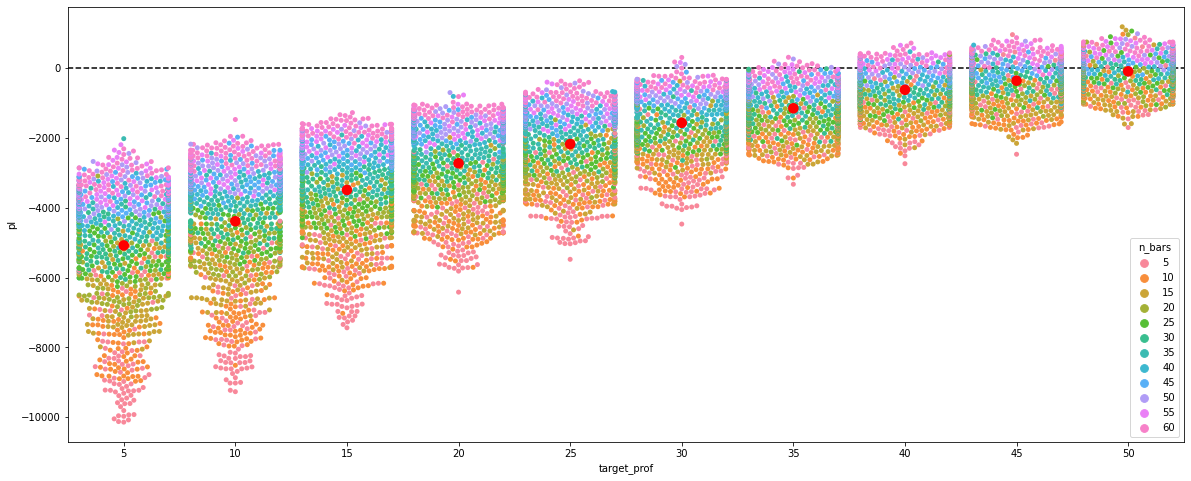

In [30]:
# 目標利益ポイント（target_prof）と総損益（pl）の関係
"""
- 目標利益が高いほど総損益は大きい。
- 目標利益の値によらず、最大保有期間が長いほど総損益は大きい。
- 目標利益について、全ての条件で総損益の平均値はマイナス。
"""

pl_mean = df.groupby('target_prof')['pl'].mean()

fig = plt.figure(figsize=(20, 8))

ax = sns.pointplot(pl_mean.index, pl_mean, linestyles='', marker='.', color='red', scale=1.2)
# pointplotのzorderはいつも一番小さい値になってしまうらしい。
# seabornではプロット関数の引数にzorder=XXという設定ができないから、以下のようにハックする
# ref: https://stackoverflow.com/questions/32281580/using-seaborn-how-do-i-get-all-the-elements-from-a-pointplot-to-appear-above-th
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.swarmplot('target_prof', 'pl', hue='n_bars', data=df, ax=ax)
ax.plot([-1, 11], [0, 0], color='black', linestyle='--')

<Figure size 1440x1440 with 0 Axes>

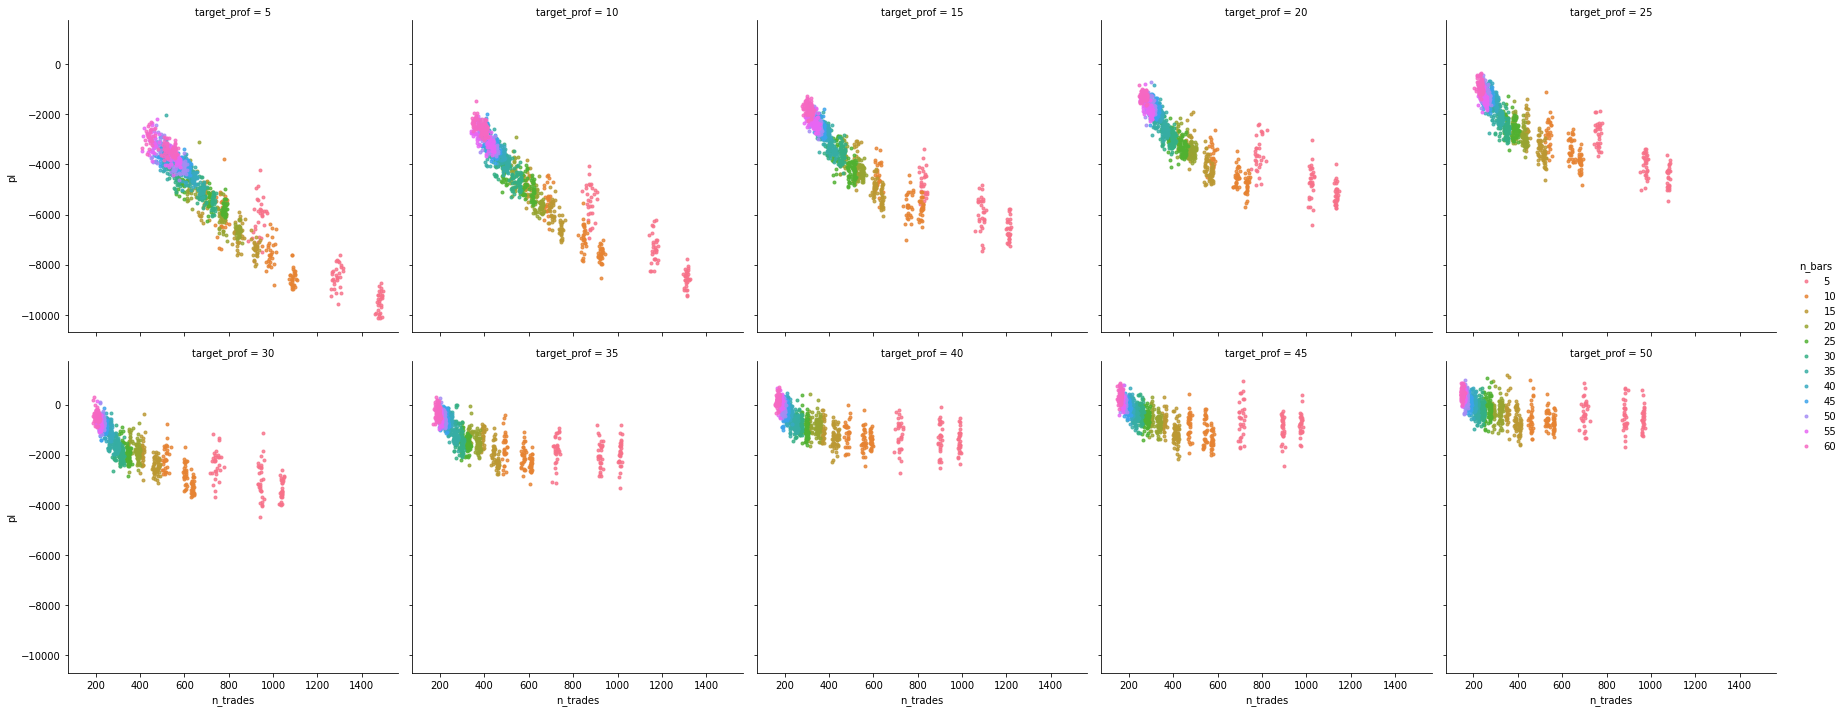

In [46]:
# トレード回数と総損益の関係
"""
- トレード回数が多いほど総損益が小さい。これは最大保有期間が短くなる（＝トレード回数が増える）ほど総損益が小さくなることによる。
- 最大保有期間が長い時は、1条件内でもトレード回数と総損益の間には負の相関が見られる。そしてその傾向は目標利益が小さいほど顕著になる。
  つまり、目標利益が小さく最大保有期間が長いほどトレード回数と総損益の負相関が強くなる。
  これはもし平均損益がトレード回数によらないあるいはあまり変化しない（そしてその平均損益の不変性が目標利益と負相関し最大保有期間と正相関する）と仮定すれば妥当な結果。
  もしそうだとすれば、平均損益がプラスの時はトレード回数が多いほど総損益も大きくなると予想される。
- 最大保有期間が短い時は、1条件内でもトレード回数と総損益の間には負の相関が見られる。そしてその傾向は目標利益が小さいほど顕著になる。  
"""
plt.figure(figsize=(20,20))
sns.lmplot('n_trades', 'pl', hue='n_bars', col='target_prof', col_wrap=5, data=df, fit_reg=False, markers='.')

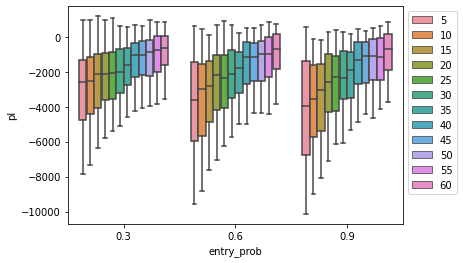

In [70]:
# 仕掛け確率と総損益との関係
"""
- 最大保有期間が短い時に、仕掛け確率と総損益の間に弱い負相関が見られる
"""

sns.boxplot('entry_prob', 'pl', hue='n_bars', data=df)
plt.legend(bbox_to_anchor=(1,1))

top 5 of pl mean: [((50, 60), 475.9277777777778), ((45, 60), 358.24444444444447), ((50, 55), 346.4166666666667), ((50, 50), 236.58333333333334), ((40, 60), 206.24722222222223)]
max loss in 1 trade when target_prof=50 and n_bars=60: -540.5


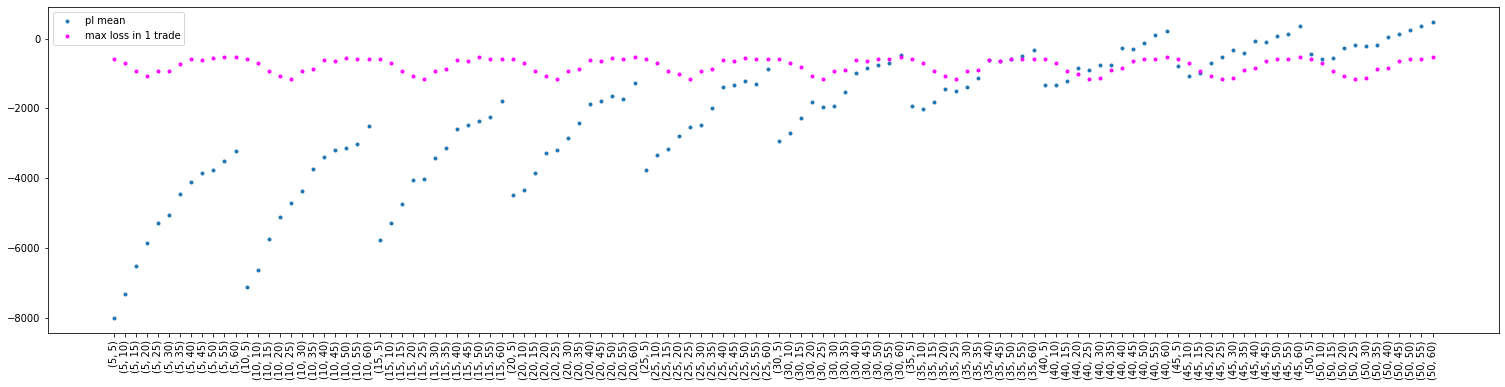

In [99]:
# 目標利益と最大保有期間の条件組み合わせの中で総損益の平均値のランキング
"""
- 仕掛け確率については総損益との間に強い相関は見られなかったためここでは、目標利益と最大保有期間にのみ注目した
- 目標利益=50、最大保有期間=60、という共に最大値の時に総損益が最大となった。その時の総損益は475.9
"""
df_mean_2_cond = df.groupby(['target_prof', 'n_bars'])['pl'].mean()
mean_2_cond = sorted(zip(df_mean_2_cond.keys(), df_mean_2_cond.values), key=lambda x: x[1], reverse=True)
print('top 5 of pl mean:', mean_2_cond[:5])

max_loss_in1_mean = df.groupby(['target_prof', 'n_bars'])['max_loss_in1'].min()
print(f'max loss in 1 trade when target_prof=50 and n_bars=60: {max_loss_in1_mean[50, 60]}')

plt.figure(figsize=(26, 6))
plt.plot(range(len(df_mean_2_cond.values)), df_mean_2_cond.values, linestyle='', marker='.', label='pl mean')
plt.plot(range(len(max_loss_in1_mean.values)), max_loss_in1_mean.values, linestyle='', marker='.', color='magenta', label='max loss in 1 trade')
plt.xticks(range(len(df_mean_2_cond.values)), df_mean_2_cond.keys(), rotation=90)
plt.legend()

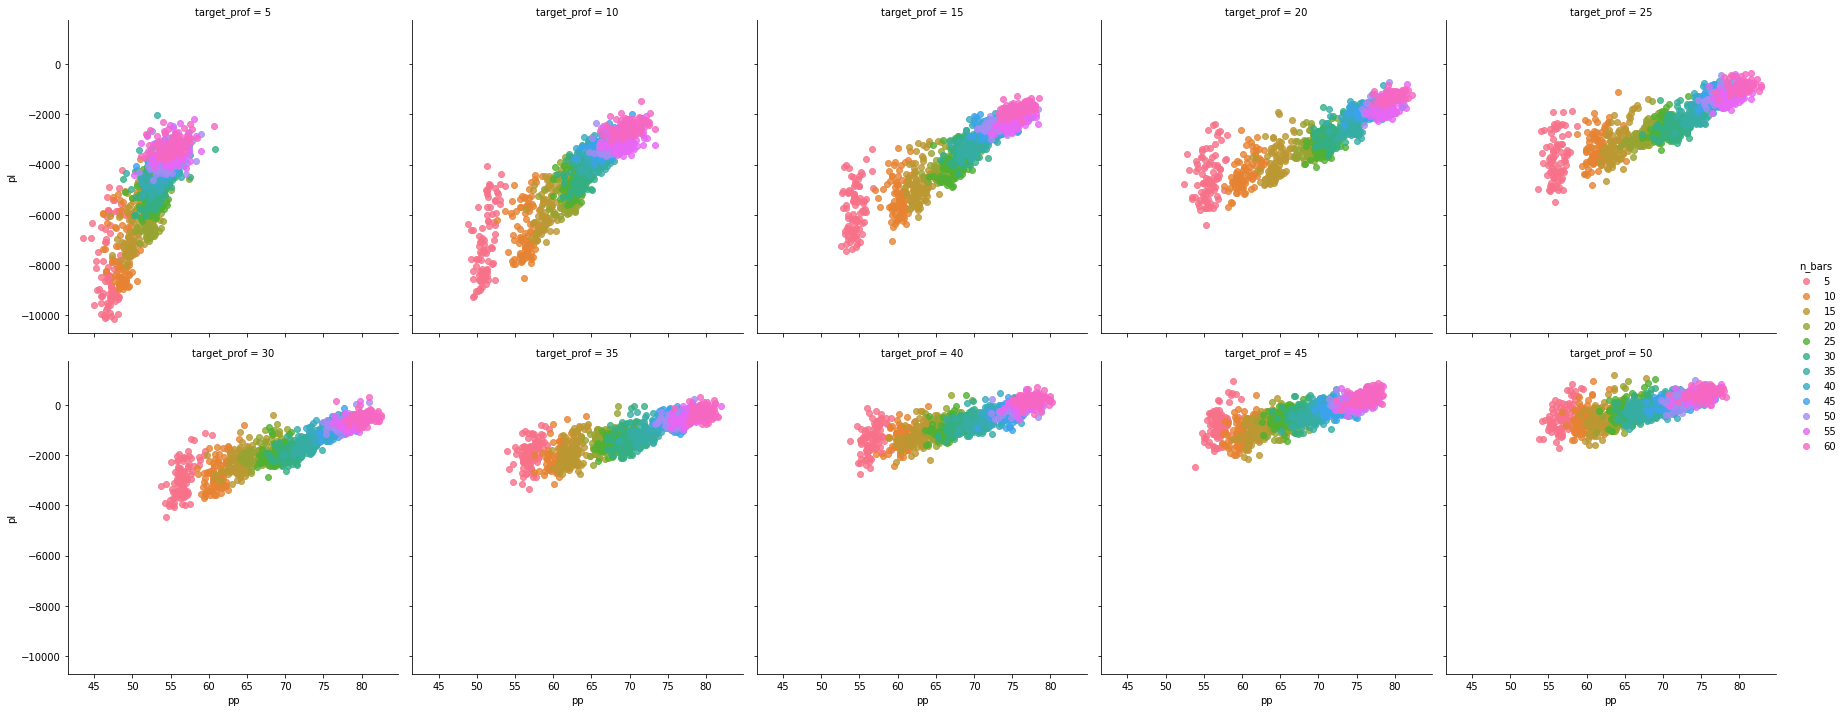

In [102]:
# 勝率と総損益の関係
"""
- 勝率と総損益は正相関
- 最大保有期間と総損益は正相関
- 目標利益が大きいほど勝率と総損益の相関は弱くなる
"""
sns.lmplot('pp', 'pl', hue='n_bars', col='target_prof', col_wrap=5, data=df, fit_reg=False)